In [1]:
%load_ext autoreload
%autoreload 2 -p

# Climada Days `supplychain` refactoring handout

In [1]:
import datetime as dt

import numpy as np
import pandas as pd
from climada.engine.impact_calc import ImpactCalc
from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.util.api_client import Client
from climada_petals.engine.supplychain import BoARIOModel, DirectShock, StaticIOModel
from climada_petals.engine.supplychain.mriot_handling import *
from climada_petals.engine.supplychain.utils import *

client = Client()

ERROR 1: PROJ: proj_create_from_database: Open of /home/sjuhel/miniforge3/envs/climada_petals_dev/share/proj failed
/home/sjuhel/miniforge3/envs/climada_petals_dev/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
08:36:01 - boario - [INFO] - Unable to tell git branch as pygit2 was not found.
08:36:01 - boario - [INFO] - Loaded boario module. You can disable logging in console with `boario.disable_console_logging()`.


## Calculate direct economic impacts

The first step is to conduct a direct impact analysis. To do so, we need to define an exposure, a hazard and a vulnerability. In this tutorial we will load the LitPop exposure for Japan from the CLIMADA Data API.

In [2]:
from climada.entity import LitPop

exp_jpn = client.get_litpop("JPN")

2024-10-22 08:36:04,007 - climada.util.api_client - WARNING - there is no internet connection but the client has stored the results of this very request sometime in the past.
2024-10-22 08:36:04,009 - climada.entity.exposures.base - INFO - Reading /home/sjuhel/climada/data/exposures/litpop/LitPop_150arcsec_JPN/v3/LitPop_150arcsec_JPN.hdf5


Then, we load tropical cyclones that hit Japan in 2015 from the CLIMADA Data API.
We define vulnerability by loading impact functions for tropical cyclones in Japan, and finally calculate the impacts.

In [3]:
tc_jpn = client.get_hazard(
    "tropical_cyclone",
    properties={"country_iso3alpha": "JPN", "event_type": "observed"},
)

target_year = 2019
events_in_target_year = np.array(
    [
        tc_jpn.event_name[i]
        for i in range(len(tc_jpn.event_name))
        if dt.datetime.fromordinal(tc_jpn.date[i]).year == target_year
    ]
)

tc_jpn_target_year = tc_jpn.select(event_names=events_in_target_year)

# Define impact function
impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_set = ImpactFuncSet()
impf_set.append(impf_tc)
impf_set.check()

# Calculate direct impacts to JPN due to TC
imp_calc = ImpactCalc(exp_jpn, impf_set, tc_jpn_target_year)
direct_impact_jpn = imp_calc.impact()

2024-10-22 08:36:04,228 - climada.util.api_client - WARNING - there is no internet connection but the client has stored the results of this very request sometime in the past.
2024-10-22 08:36:04,230 - climada.hazard.io - INFO - Reading /home/sjuhel/climada/data/hazard/tropical_cyclone/tropical_cyclone_0synth_tracks_150arcsec_historical_JPN_1980_2020/v2/tropical_cyclone_0synth_tracks_150arcsec_historical_JPN_1980_2020.hdf5
2024-10-22 08:36:04,255 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard TC. Using the anonymous 'impf_' column.
2024-10-22 08:36:04,257 - climada.entity.exposures.base - INFO - Matching 21999 exposures with 21962 centroids.
2024-10-22 08:36:04,260 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-10-22 08:36:04,286 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 1 coordinates.
2024

## Calculate indirect economic impacts

### Load an MRIOT

We load an MRIOT from the available ones:

In [4]:
mriot = get_mriot("WIOD16", 2010, save=True)

`mriot` is a `pymrio.IOSystem`, representing a Multi-Regional Input Output Table (MRIOT). You can have a look at [pymrio's documentation](https://pymrio.readthedocs.io/en/latest/) to better understand this object.

Here are some important available attributes or methods, which you can have a look at:

- mriot.Z : the inter-industry flow matrix (also named intermediate demand or transaction matrix), i.e., the absolute flow of goods from region,sector to region,sector (used to produce new goods) in monetary terms.
- mriot.Y : the final demand matrix, i,e, the absolute flow of goods from region,sector to region (used as final products by consummers) in monetary terms. Often subdivided into final demand categories (state, households, etc).
- mriot.x : the absolute total amout of goods produced by each region, sector, should be equal to the sum of Z and Y (summing the columns together)
- mriot.A : the technical coefficient matrix
- mriot.get_sectors() : the sector typology
- mriot.get_regions() : the region typology

### Instantiate a DirectShock object

The minimum requirement to instantiate a `DirectShock` are:
- an MRIOT,
- an Exposures,
- an Impact,
- the list of sectors affected by the Impact,
- and how the impact is distributed to the sectors.

In [6]:
direct_shock = DirectShock.from_exp_and_imp(
    mriot=mriot,
    exposure=exp_jpn,
    impact=direct_impact_jpn,
    shock_name="TCs in JPN",
    affected_sectors=["Forestry and logging","Manufacture of motor vehicles, trailers and semi-trailers", "Mining and quarrying"],
    impact_distribution=None,  # None distribute the impact by the production
)

2024-10-22 08:37:10,242 - climada.util.coordinates - INFO - Setting region_id 21999 points.


You can have a look at the different attributes and methods available (mainly those not starting by "_"):

In [15]:
[avail for avail in direct_shock.__dir__() if avail[0] != "_"]

['mriot_sectors',
 'mriot_regions',
 'mriot_industries',
 'mriot_name',
 'monetary_factor',
 'name',
 'exposure_assets',
 'impacted_assets',
 'event_dates',
 'relative_impact',
 'from_exp_and_imp',
 'from_assets_and_imp',
 'combine']

Mainly the object stores the "translated" exposure and impact:

In [16]:
# Subselect the non zero values
direct_shock.exposure_assets.loc[lambda x: x != 0]

region  sector                                                   
JPN     Forestry and logging                                         3.760612e+05
        Manufacture of motor vehicles, trailers and semi-trailers    1.692583e+07
        Mining and quarrying                                         1.603689e+06
dtype: float64

In [17]:
direct_shock.impacted_assets.loc[
    direct_shock.impacted_assets.ne(0).any(axis=1),
    direct_shock.impacted_assets.ne(0).any(axis=0),
]

region                    JPN  \
sector   Forestry and logging   
event_id                        
3236                 0.000315   
3242                 5.271078   
3243                 0.010664   
3244                38.337255   
3248               821.041044   
3250                 2.049857   
3253               220.733284   
3254                 0.000030   
3255              6977.844799   
3257                 0.001525   

region                                                              \
sector   Manufacture of motor vehicles, trailers and semi-trailers   
event_id                                                             
3236                                               0.014181          
3242                                             237.241644          
3243                                               0.479978          
3244                                            1725.490101          
3248                                           36953.564080          
3250                                              92.260325          
3253                                            9934.803622          
3254                                               0.001354          
3255                                          314060.103045          
3257                                               0.068660          

region                         
sector   Mining and quarrying  
event_id                       
3236                 0.001344  
3242                22.478182  
3243                 0.045477  
3244               163.486818  
3248              3501.278036  
3250                 8.741486  
3253               941.303243  
3254                 0.000128  
3255             29756.581490  
3257                 0.006505

### Leontief (and Ghosh) static models (complement to the presentation)

The mathematical idea behind Input-Output (I-O) analysis revolves around using linear algebra to represent the interconnections between industries in an economy. It’s based on the Leontief model, named after economist Wassily Leontief, who developed the theory circa 1960.

The main goal is to see how changes in demand affect the entire economic system by solving for the total output required to meet that demand, through the "Leontief inverse". This matrix shows how a change in final demand for one industry’s output affects the overall economy (assuming the "recipes" of production and the trade relationship remain the same).

In the Ghosh model, the focus is on how changes in the supply of inputs (like raw materials or labor) affect the total output of industries.
Note however that the Ghosh model assumes a supply-driven economie, which is in general not verified. Thus results with this approach should be taken with caution.

In the module we employ the already well implemented methods of the `pymrio` package.

In [78]:
model = StaticIOModel(mriot, direct_shock)

In [79]:
res = model.calc_indirect_impacts()

`res` contains the results per (event, region, sector, method), where the method is either the Leontief (shock assumed as a degraded demand) or the Ghosh approach (shock assumed as a degraded value added), and three different metrics:

1. absolute production change: the absolute loss or gain of production
2. relative production change: the change in production relative to the original production in the MRIOT
3. production lost to shock ratio: the change in production relative to the direct impact on the (region,sector).

Note the presence of NaN due to some sectors in some regions having 0. production.
As well as the presence of Inf values for 3. for non impacted (region,sectors)
Any suggestions on how to handle these case are welcome.

In the future, I will probably add "change in production relative to the total direct impact" (which has a value for all (region, sector) instead of only the affected ones).

In [80]:
# For the moment let us drop the NaNs.
res = res.dropna(how="any", axis=0)

The tidy format of the results should allow for easy plotting and data manipulation:

#### Top ten impacted sectors in Japan (relative to their production), with the Leontief method:

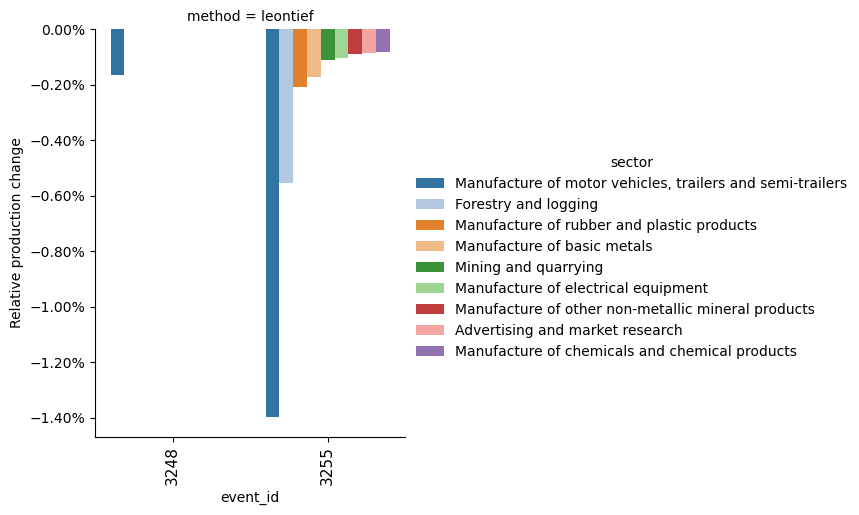

In [81]:
import seaborn as sns
from matplotlib.ticker import PercentFormatter

plot_df = res.copy()
plot_df = plot_df.loc[
    (plot_df["region"] == "JPN")
    & (plot_df["metric"] == "relative production change")
    & (plot_df["method"] == "leontief")
].sort_values("value").head(10)

g = sns.catplot(
    plot_df,
    kind="bar",
    x="event_id",
    y="value",
    hue="sector",
    row="method",
    #aspect=4,
    palette="tab20",
    # col = "metric"
)

g.set_ylabels("Relative production change")
g.axes.flat[0].yaxis.set_major_formatter(PercentFormatter(1))

# g.axes
g.set_xticklabels(g.axes[0, 0].get_xticklabels(), rotation=90, fontsize=11)

#### Top ten impacted sectors outside Japan (relative to their production), with the Leontief method:

Note how the impacts are two orders of magnitude bellow the previous ones.

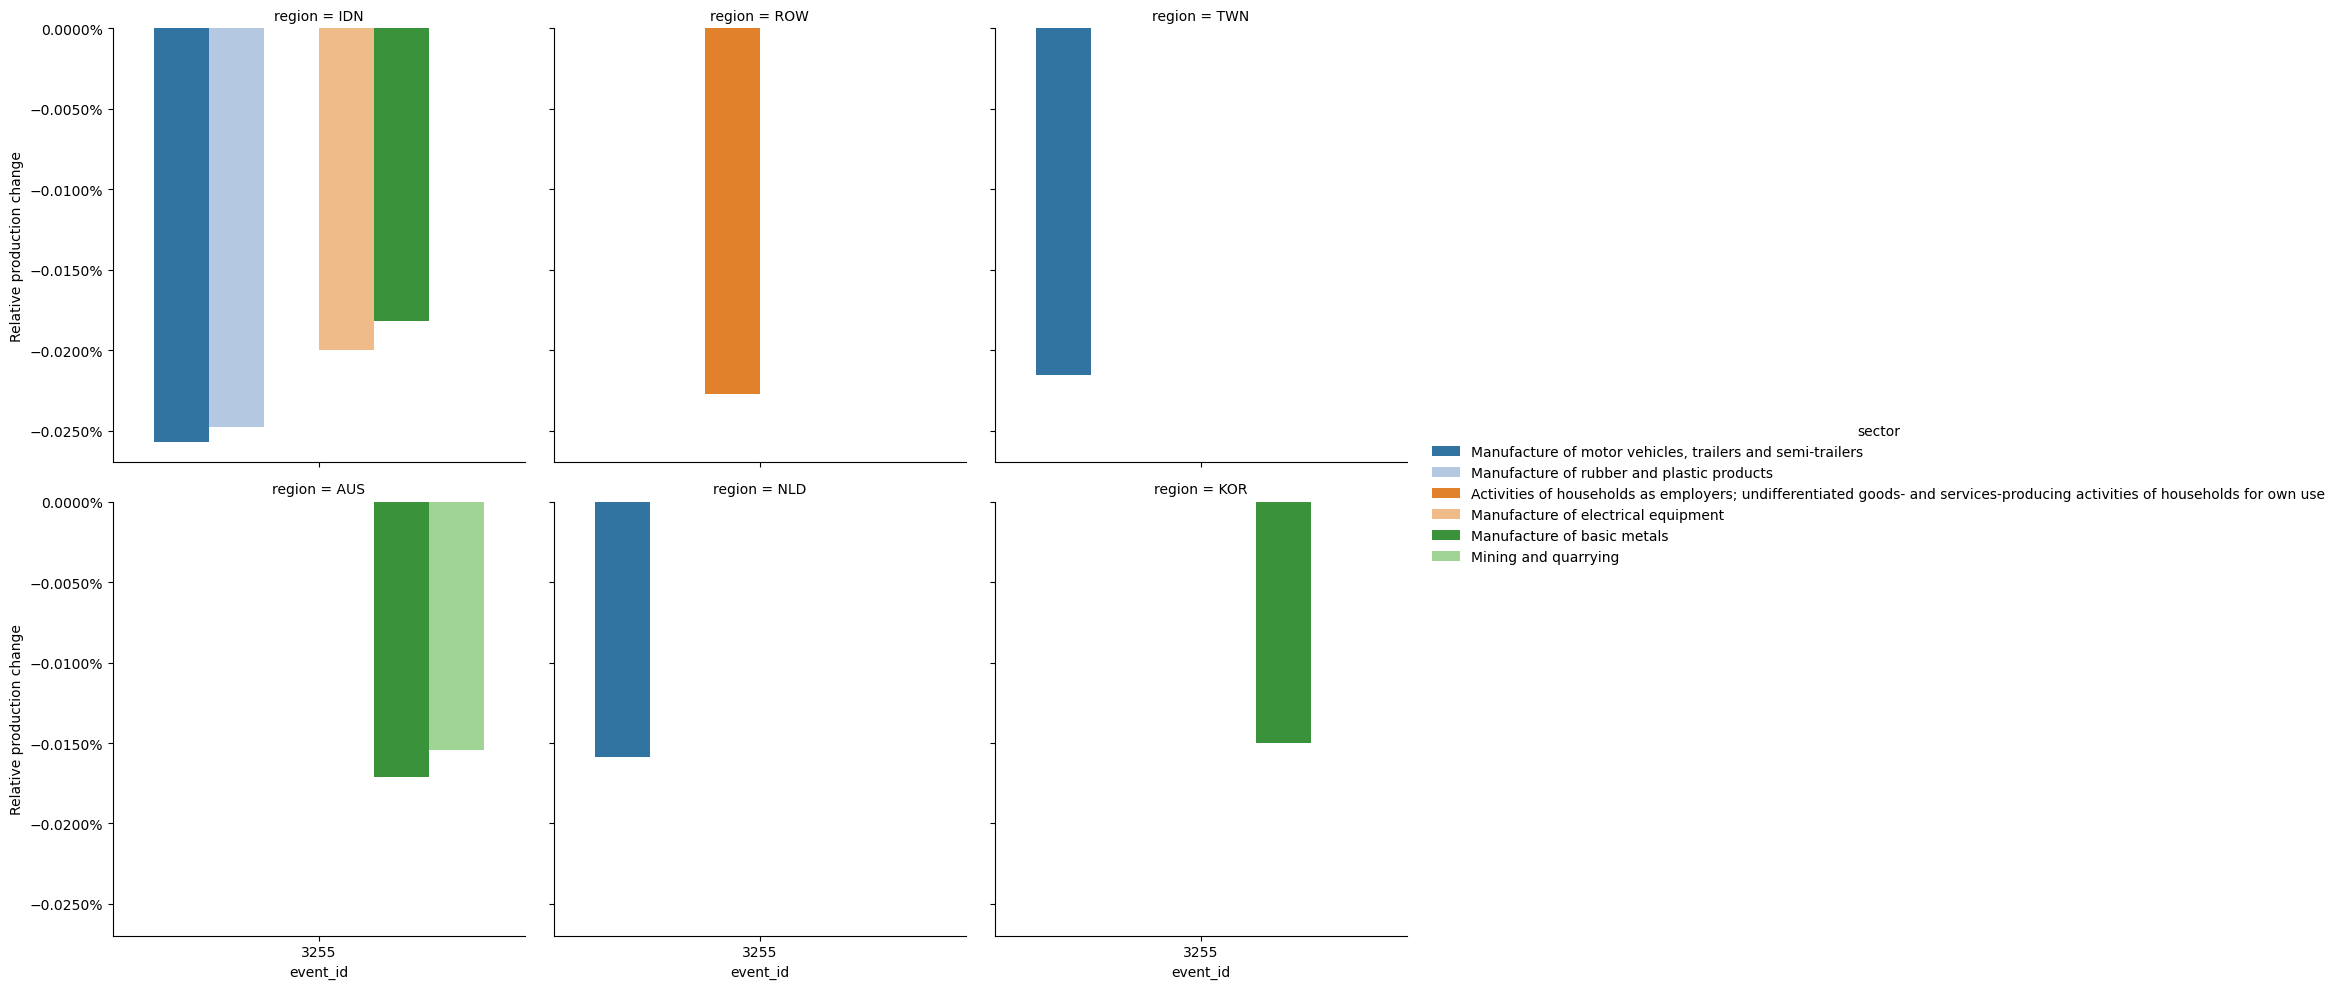

In [82]:
import seaborn as sns
from matplotlib.ticker import PercentFormatter

plot_df = res.copy()
plot_df = plot_df.loc[
    (plot_df["region"] != "JPN")
    & (plot_df["metric"] == "relative production change")
    & (plot_df["method"] == "leontief")
].sort_values("value").head(10)

g = sns.catplot(
    plot_df,
    kind="bar",
    x="event_id",
    y="value",
    hue="sector",
    col="region",
    col_wrap=3,
    palette="tab20",
    # col = "metric"
)

g.set_ylabels("Relative production change")
g.axes.flat[0].yaxis.set_major_formatter(PercentFormatter(1))

#### Your turn:

Play with the module:
- Compare the two methods
- plot aggregated impacts
- test impacts (eg, on a different set of sectors, from a different hazard, etc.)

Please note down anything that:

- Does not work (or is counterintuitive)
- Is not present and would be appreciated
- Seems weird in the results
- You think should be brought up

### Dynamic models

Static I-O models simply compute the change in equilibrium due to a shock. As such the recovery phase (and possible arising complications) is not accounted for.

Dynamic models fill this gap. There is a vast literature on the subject as many types of model exists, and it cannot be summarised within this workshop notebook. 
In addition, only the ARIO model is currently available within the module, via the `boario` package.

If you are interested feel free to get in touch, and I can also suggest these two reviews: 

1. Botzen et al. 2019. https://www.journals.uchicago.edu/doi/10.1093/reep/rez004
2. Coronese, Luzatti. 2022. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4101276

#### ARIO with `BoARIO`

Disclaimer: 

The development of BoARIO 0.6 and this supplychain module are being done in parallel. Notably because this new version of BoARIO implements major changes that a) facilitate coupling and b) will break retrocompatibility. 

The this new version is also a huge overhaul of the model engine, which is not yet fully debugged, and a lot of features are still broken. 

Thus, this part of the handout is more of a showcasing of the limited aspects that are working (or at least running).

Feel free to change the code to try out other impacts or feature, but expect bugs!

-------------------------------

The ARIO model offers a more "advanced" approach to compute indirect impacts. To understand more about the model we refer you to its seminal papers [Hallegatte 2008](https://doi.org/10.1111/j.1539-6924.2008.01046.x) and [Hallegatte 2013](https://doi.org/10.1111/risa.12090), as well as [the documentation](https://spjuhel.github.io/BoARIO/boario-what-is.html) of the `boario` package which is the implementation used in CLIMADA.

`boario` implements different kind of events, to account for a broad typology of impacts:
- `recovery` events, where the direct impact is translated into a loss of production capacity which is recovered over time exogenously.
- `rebuild` events, where the direct impact is translated into a loss of productive capital (assets) resulting in a loss of production capacity. In this case assets are also recovered over time, but through an endogenous reconstruction, which involves an additional final demand in the model. *This feature appears to be broken at the moment*

For more details, we again refer to the `boario` documentation on [How to define events](https://spjuhel.github.io/BoARIO/tutorials/boario-events.html)

In [20]:
# We redefine a direct shock on all sectors this time
direct_shock = DirectShock.from_exp_and_imp(
    mriot,
    exp_jpn,
    direct_impact_jpn,
    shock_name="TCs in JPN",
    affected_sectors="all",
    impact_distribution=None,
)

There are multiple things that can be paramterized within `boario`, the simulation itself, as well as the model and the events. 

These parameters are passed to the package using three dictionnary read as kwargs by the different modules/classes of the boario package. This aspect still requires work as some parameters configurations may conflict with the coupling.

If you want to dig deeper, have a look at:

- https://spjuhel.github.io/BoARIO/tutorials/simulation-context.html and https://spjuhel.github.io/BoARIO/develop/en/_autosummary/boario.simulation.Simulation.html for simulation parameters
- https://spjuhel.github.io/BoARIO/develop/en/_autosummary/boario.extended_models.ARIOPsiModel.html for the model
- https://spjuhel.github.io/BoARIO/develop/en/_autosummary/boario.event.html for the events

Sadly the documentation is not yet updated with the latest changes from 0.6.0, don't hesitate to ask if you try something and it doesn't work.

In [ ]:
dyn_model = BoARIOModel(
    mriot,
    direct_shock,
    simulation_kwargs={"show_progress": True},
    model_kwargs={"order_type": "alt"},
    event_kwargs={"recovery_tau": 180},
)

18:16:40 - boario - [INFO] - IO system metadata :
Metadata for pymrio Multi Regional Input-Output Table
WIOD16-2010
None
None
/home/sjuhel/miniforge3/envs/climada_petals_dev/lib/python3.10/site-packages/boario/model_base.py:178: UserWarning: Custom monetary factor found in the mrio pickle file, continuing with this one (1000000)
  warnings.warn(
18:16:40 - boario - [INFO] - Initializing new simulation instance
18:16:40 - boario - [INFO] - Initialized !
18:16:40 - boario - [INFO] - Simulation parameters:
{'alpha_base': 1.0,
 'alpha_max': 1.25,
 'alpha_tau': 1.0,
 'inventory_restoration_tau': ['[60.0 (x 56)] (len: 56, sum: 3360.0)'],
 'model_type': 'ARIOPsiModel',
 'n_temporal_units_by_step': 1,
 'n_temporal_units_to_sim': 725,
 'order_type': 'alt',
 'output_dir': '/tmp/boariodr6wsyni',
 'psi_param': 0.8,
 'rebuild_tau': 60,
 'results_storage': 'boariodr6wsyni',
 'year_to_temporal_unit_factor': 365}
18:16:41 - boario - [INFO] - Initializing new Event
18:16:41 - boario - [INFO] - Total im

The time required to run the simulation heavily depends on the MRIOTs (the number of regions * sectors), and the number of steps to simulate of course. 
With WIOD and the choosen events, it should take around 2 minutes on a recent computer.
EXIOBASE 3 is more in the 30-45 minutes range.
An estimate of the progress should be shown during the simulation.

In [ ]:
res = dyn_model.run_sim()

18:16:43 - boario - [INFO] - Starting model loop for at most 726 steps
18:16:43 - boario - [INFO] - One step is 1/365 of a year
18:16:43 - boario - [INFO] - Events : {self.all_events}
Processed: Step: 75 ~  10% ETA:   0:02:06                 18:16:57 - boario - [INFO] - At least one industry entered shortage regime. (step:75)
Processed: Step: 178 ~  24% ETA:   0:02:19               18:17:28 - boario - [INFO] - Temporal_Unit : 178 ~ Shocking model with new event
18:17:28 - boario - [INFO] - Affected regions are : ['JPN']
Processed: Step: 179 ~  24% ETA:   0:02:19               18:17:29 - boario - [INFO] - Temporal_Unit : 179 ~ Event named None that occurred at 178 in ['JPN'] is now considered finished
Processed: Step: 214 ~  29% ETA:   0:02:16               18:17:40 - boario - [INFO] - Temporal_Unit : 214 ~ Shocking model with new event
18:17:40 - boario - [INFO] - Affected regions are : ['JPN']
Processed: Step: 215 ~  29% ETA:   0:02:16               18:17:40 - boario - [INFO] - Tempor

`res` contains a Simulation object from `boario` which among other things contains all the time series of the state variables.

For instance you can plot the `production_realised` in relative terms using the following:

<Axes: xlabel='step'>

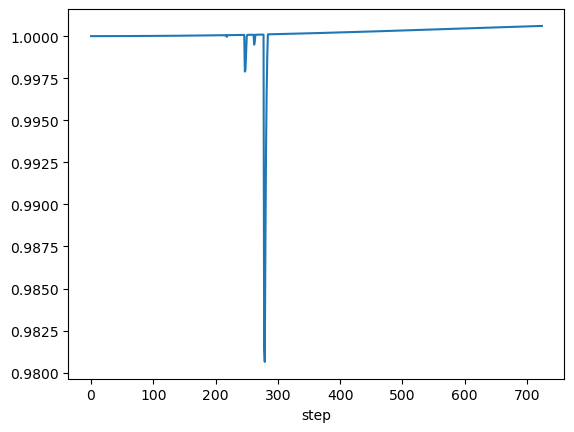

In [ ]:
(res.production_realised / res.production_realised.loc[0]).loc[
    :, ("JPN", "Manufacture of basic metals")
].plot(legend=False)